In [1]:
import numpy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM
from tqdm import tqdm
import matplotlib.pyplot as plt
import data_preprocess as minyu

/home/littlelian/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch_seed = 42 
torch.manual_seed(torch_seed)
torch.cuda.manual_seed_all(torch_seed)
torch.cuda.manual_seed(torch_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model

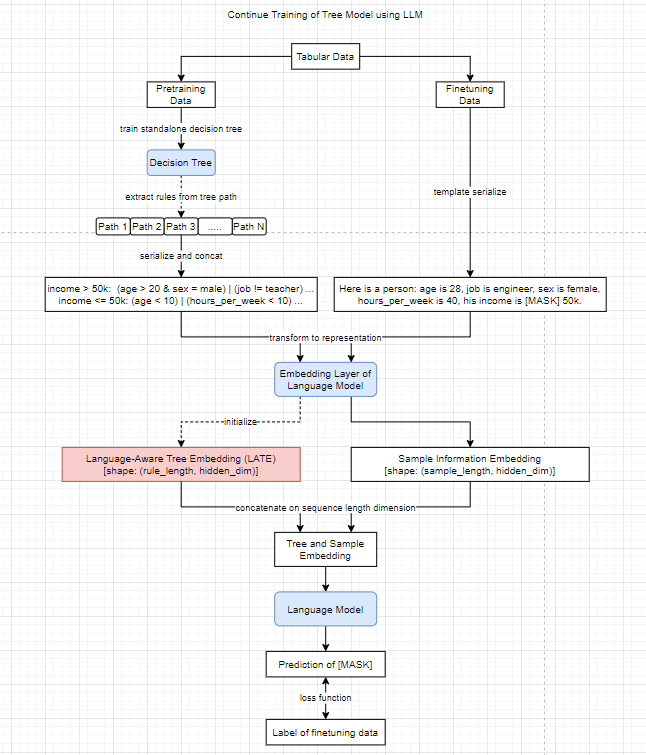

## Load Dataset

In [3]:
German_Dataset = minyu.German('cpu')
X, y = German_Dataset.preprocess()

df = pd.DataFrame(
    German_Dataset.x, 
    columns=German_Dataset.cate_name + German_Dataset.numer_name
    )
 
df['target'] = y

df.head()

,Status of existing checking account,Credit history,Purpose,Savings account/bonds,Present employment since,Personal status and sex,Other debtors / guarantors,Property,Other installment plans,Housing,...,Telephone,foreign worker,Duration,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age,Number of existing credits at this bank,Number of people being liable to provide maintenance for,target
0,A11,A34,A43,A65,A75,A93,A101,A121,A143,A152,...,A192,A201,6,1169,4,4,67,2,1,0
1,A12,A32,A43,A61,A73,A92,A101,A121,A143,A152,...,A191,A201,48,5951,2,2,22,1,1,1
2,A14,A34,A46,A61,A74,A93,A101,A121,A143,A152,...,A191,A201,12,2096,2,3,49,1,2,0
3,A11,A32,A42,A61,A74,A93,A103,A122,A143,A153,...,A191,A201,42,7882,2,4,45,1,2,0
4,A11,A33,A40,A61,A73,A93,A101,A124,A143,A153,...,A191,A201,24,4870,3,4,53,2,2,1


In [4]:
df['target'].value_counts()
# It's balanced

0    700
1    300
Name: target, dtype: int64

In [5]:
# split dataset into pretrained_data and finetune_data
X_pre, X_fine, y_pre, y_fine = train_test_split(X, y, test_size=0.2, random_state=torch_seed, stratify=y)

## Decision Tree

In [6]:
Tree_model = DecisionTreeClassifier(max_depth=3, random_state=torch_seed)
Tree_model.fit(X_pre, y_pre)

# Show rules
rule_text = tree.export_text(Tree_model, feature_names=German_Dataset.cate_name + German_Dataset.numer_name)
print(rule_text)

|--- Status of existing checking account <= 1.50
|   |--- Credit history <= 22.50
|   |   |--- Purpose <= 1.50
|   |   |   |--- class: 1
|   |   |--- Purpose >  1.50
|   |   |   |--- class: 0
|   |--- Credit history >  22.50
|   |   |--- Personal status and sex <= 2.50
|   |   |   |--- class: 1
|   |   |--- Personal status and sex >  2.50
|   |   |   |--- class: 0
|--- Status of existing checking account >  1.50
|   |--- Duration <= 0.50
|   |   |--- Present employment since <= 3741.00
|   |   |   |--- class: 0
|   |   |--- Present employment since >  3741.00
|   |   |   |--- class: 1
|   |--- Duration >  0.50
|   |   |--- Other debtors / guarantors <= 1.50
|   |   |   |--- class: 0
|   |   |--- Other debtors / guarantors >  1.50
|   |   |   |--- class: 0



In [7]:
rule_text = '''
Class 1: If (Status of existing checking account less than or equal to 1.50 AND Credit history less than or equal to 22.50 AND Purpose less than or equal to 1.50) OR (Status of existing checking account less than or equal to 1.50 AND Credit history bigger than 22.50 AND Personal status and sex less than or equal to 2.50) OR (Status of existing checking account bigger than 1.50 AND Duration less than or equal to 0.50 AND Present employment since bigger than 3741.00).
Class 0: If (Status of existing checking account less than or equal to 1.50 AND Credit history less than or equal to 22.50 AND Purpose bigger than 1.50) OR (Status of existing checking account less than or equal to 1.50 AND Credit history bigger than 22.50 AND Personal status and sex bigger than 2.50) OR (Status of existing checking account bigger than 1.50 AND Duration bigger than 0.50) OR (Status of existing checking account bigger than 1.50 AND Duration less than or equal to 0.50 AND Present employment since bigger than  3741.00).
'''

In [8]:
Decision_train_acc = Tree_model.score(X_pre, y_pre)
print(Decision_train_acc)
Decision_tree_acc = Tree_model.score(X_fine, y_fine)
print(Decision_tree_acc)

0.765
0.75


In [9]:
def rule_of_sample(X, feature_names):
    sample = 'It belongs to Class [MASK] because '
    for i in range(len(X)):
        sample += f'{feature_names[i]} is {X[i]}, '
    sample = sample[:-2] + '.'
    return sample
    
print(rule_of_sample(X_pre[0], German_Dataset.cate_name + German_Dataset.numer_name))

It belongs to Class [MASK] because Status of existing checking account is 0.0, Credit history is 36.0, Purpose is 2.0, Savings account/bonds is 1.0, Present employment since is 8335.0, Personal status and sex is 4.0, Other debtors / guarantors is 4.0, Property is 3.0, Other installment plans is 2.0, Housing is 0.0, Job is 4.0, Telephone is 3.0, foreign worker is 47.0, Duration is 2.0, Credit amount is 2.0, Installment rate in percentage of disposable income is 1.0, Present residence since is 2.0, Age is 1.0, Number of existing credits at this bank is 0.0, Number of people being liable to provide maintenance for is 0.0.


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bertmodel = BertForMaskedLM.from_pretrained('bert-base-uncased')
for param in bertmodel.parameters():
    param.requires_grad = False

AttributeError: module 'torch' has no attribute 'frombuffer'

In [ ]:
rule_text_token = tokenizer(rule_text, return_tensors="pt")
rule_text_emb = bertmodel.bert.embeddings(input_ids=rule_text_token['input_ids'], token_type_ids=rule_text_token['token_type_ids'])
print(rule_text_emb.shape)

In [ ]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device("cuda:1")

In [ ]:
class LLMTree(nn.Module):
    def __init__(self, LLM_model, LLM_tokenizer, batch_size, device):
        super(LLMTree, self).__init__()
        self.LLM_model = LLM_model
        self.LLM_emb_layer = LLM_model.bert.embeddings
        self.tokenizer = LLM_tokenizer
        self.LLM_hidden_dim = 768
        self.class_num = 3
        self.batch_size = batch_size
        self.feature_names = Iris_Dataset.feature_names
        self.rule_emb = rule_text_emb
        
    def rule_of_sample(self, X):
        batch_sample = []
        for n in range(len(X)):
            sample = 'It belongs to Class [MASK] because '
            for i in range(len(X[n])):
                sample += f'{self.feature_names[i]} is {X[n][i]}, '
            sample = sample[:-2] + '.'
            batch_sample.append(sample)
        return batch_sample
    
    def cal_loss(self, pred, target):
        self.criterion = nn.CrossEntropyLoss()

        return self.criterion(pred, target)
        
    def forward(self, x, device):
        x = self.tokenizer(self.rule_of_sample(x), return_tensors="pt")
        x = self.LLM_emb_layer(input_ids=x['input_ids'].to(device), token_type_ids=x['token_type_ids'].to(device))
        x = torch.cat((self.rule_emb.repeat(x.shape[0], 1, 1).to(device), x), 1)  # batch*(rule+x)*768
        x = self.LLM_model(inputs_embeds=x)['logits'] 
        return x

In [ ]:
model = LLMTree(bertmodel, tokenizer, 1, device).to(device)

In [ ]:
# class_token = 'setosa versicolor virginica'
class_token = '0 1 2'
class_token = tokenizer(class_token, return_tensors="pt")
print(class_token)

In [ ]:
train_acc = 0
for i, x in enumerate(tqdm(X_pre)):
    x = torch.tensor(x).unsqueeze(dim=0).to(device)
    pred = model(x, device)
    print(pred[0, -47, 1014:1017])
    pred = pred[0, -47, 1014:1017].argmax(0).cpu().detach().numpy()
    if pred == y_pre[i]:
        train_acc += 1
print(f'pretrain acc : {train_acc / len(X_pre)}')

test_acc = 0
for i, x in enumerate(tqdm(X_fine)):
    x = torch.tensor(x).unsqueeze(dim=0).to(device)
    pred = model(x, device)
    pred = pred[0, -47, 1014:1017].argmax(0).cpu().detach().numpy()
    if pred == y_fine[i]:
        train_acc += 1
print(f'finetune acc : {test_acc / len(X_fine)}')

In [ ]:
print(tokenizer.decode([2465, 1015, 2138]))